## Conveyor Waste Detection with YOLOv8

This Jupyter notebook demonstrates a professional computer vision project for detecting plastic waste (PET and PP) on a conveyor belt using the YOLOv8 model. The dataset, sourced from Kaggle, contains images with polygon annotations representing rectangular bounding boxes for two classes: PET (Polyethylene Terephthalate) and PP (Polypropylene). We convert these annotations to YOLOv8’s bounding box format, train a model, evaluate its performance, and visualize results to create a portfolio piece suitable for LinkedIn and GitHub.

**1. Project Setup**

**Overview**

We begin by setting up the environment, importing necessary libraries, and defining the dataset path. We also check for GPU availability to accelerate training.

In [24]:
import os
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from collections import Counter
from tqdm.notebook import tqdm
from ultralytics import YOLO
from torch.utils.data import DataLoader
from ultralytics.data.dataset import YOLODataset
import torch
import pandas as pd
import seaborn as sns
import gc

**GPU Check**

To optimize training, we'll check if a GPU is available:

In [28]:
# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


In [4]:
# Define dataset path
dataset_path = Path(r"E:\My Courses\CV Projects\01- Optical detection of plastic waste\Conveyor Waste Detection Dataset\yolo")

## 2. Data Exploration

**Dataset Structure**

The dataset is organized into train, valid, and test folders, each containing images and labels subfolders. Labels are in polygon format with a class ID (0 for PET, 1 for PP) followed by 10 normalized coordinates representing a closed polygon with 5 points (the last point repeats the first). The chart above shows the distribution of images across splits.

I**mage and Class Distribution**

We count the images in each split and analyze the class distribution to understand the dataset’s composition. The second chart above visualizes the class distribution.

In [5]:
# Define splits and class names
splits = ['train', 'valid', 'test']
class_names = ['PET', 'PP']

# Count images in each split
image_counts = {split: len(list((dataset_path / split / 'images').glob('*.jpg'))) for split in splits}
print("Image counts per split:")
for split, count in image_counts.items():
    print(f"{split.capitalize()}: {count} images")

Image counts per split:
Train: 1440 images
Valid: 160 images
Test: 300 images


In [6]:
# Count class occurrences
class_counts = Counter()
for split in splits:
    label_dir = dataset_path / split / 'labels'
    for label_file in label_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_names[class_id]] += 1
print("\nClass distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} instances")


Class distribution:
PET: 2216 instances
PP: 4817 instances


**Objects per Image**

To understand the complexity of images, we compute the number of objects per image and visualize it as a histogram.

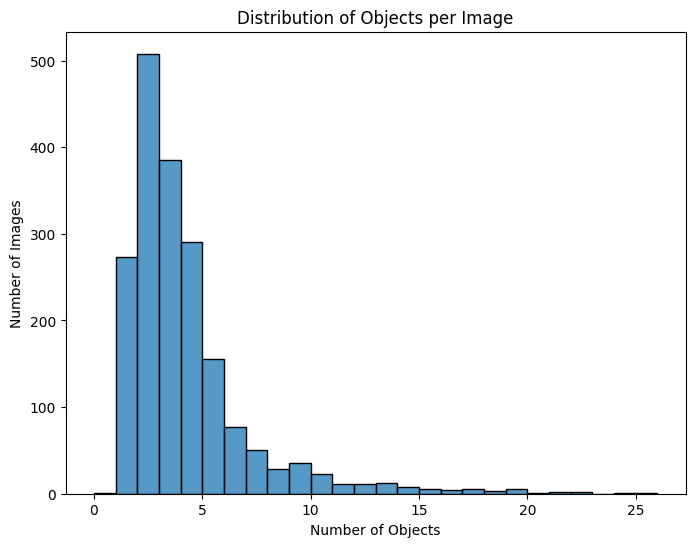

In [7]:
# Number of objects per image
objects_per_image = []
for split in splits:
    label_dir = dataset_path / split / 'labels'
    for label_file in label_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            num_objects = len(f.readlines())
            objects_per_image.append(num_objects)

# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(objects_per_image, bins=range(max(objects_per_image)+2), color='#1f77b4', edgecolor='black')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')
plt.title('Distribution of Objects per Image')
plt.show()

**Visualizing Sample Images**

We visualize a sample image with its original polygon annotations to confirm the data format. The polygons represent rectangles, as the coordinates form axis-aligned shapes.

In [8]:
def plot_image_with_polygons(image_path, label_path, class_names, img_size):
    img = Image.open(image_path)
    width, height = img_size
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            points = [float(p) for p in parts[1:]]
            x_coords = [points[i] * width for i in range(0, len(points), 2)]
            y_coords = [points[i] * height for i in range(1, len(points), 2)]
            x_coords.append(x_coords[0])  # Close the polygon
            y_coords.append(y_coords[0])
            plt.plot(x_coords, y_coords, label=class_names[class_id], linewidth=2)
            plt.text(x_coords[0], y_coords[0], class_names[class_id], color='yellow', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    plt.legend()
    plt.title("Sample Image with Polygon Annotations")
    plt.axis('off')
    plt.show()

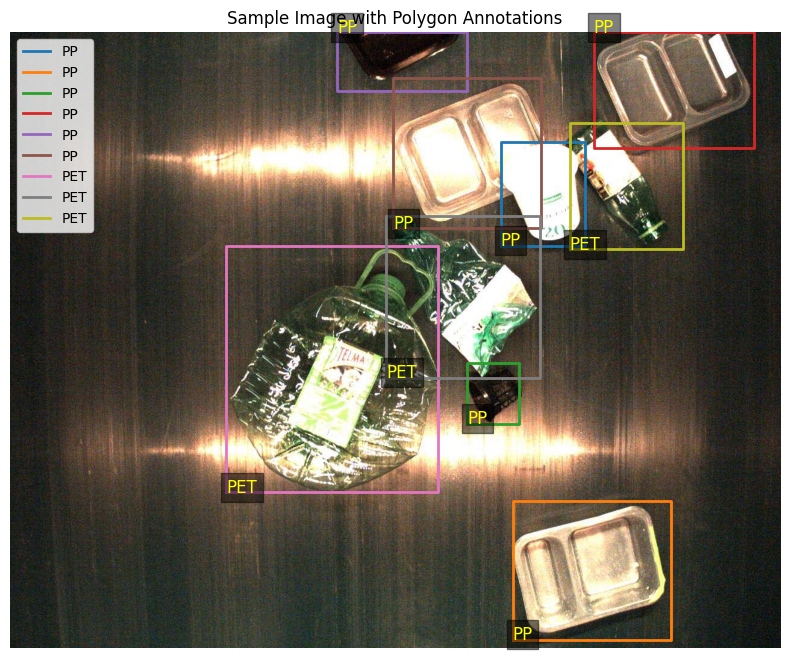

In [9]:
# Plot a sample image
sample_image = random.choice(list((dataset_path / 'train' / 'images').glob('*.jpg')))
sample_label = dataset_path / 'train' / 'labels' / (sample_image.stem + '.txt')
plot_image_with_polygons(sample_image, sample_label, class_names, (1280, 1024))

**Image Size Consistency**

All images are 1280x1024, as confirmed by the user. We verify this to ensure compatibility with YOLOv8, which resizes images to 640x640 by default, maintaining aspect ratio with padding.

In [10]:
image_sizes = set()
for split in splits:
    image_dir = dataset_path / split / 'images'
    for img_path in image_dir.glob('*.jpg'):
        with Image.open(img_path) as img:
            image_sizes.add(img.size)
print(f"Unique image sizes: {image_sizes}")

Unique image sizes: {(1280, 1024)}


## 3. Label Conversion

**Label Format**

The labels are in the format: class_id x1 y1 x2 y2 x3 y3 x4 y4 x5 y5, where coordinates are normalized (0 to 1) and represent a closed polygon with 5 points (x5,y5 = x1,y1). Analysis shows these polygons are rectangles, allowing conversion to YOLOv8’s bounding box format: class_id x_center y_center width height.

**Conversion Function**

We convert polygons to bounding boxes by finding the minimum and maximum coordinates, ensuring valid bounding boxes.

In [11]:
def convert_polygon_to_bbox(label_file, output_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 11:
            print(f"Invalid label line in {label_file}: {line}")
            continue
        class_id = parts[0]
        points = [float(p) for p in parts[1:]]
        x_values = points[0::2]
        y_values = points[1::2]
        min_x, max_x = min(x_values), max(x_values)
        min_y, max_y = min(y_values), max(y_values)
        width = max_x - min_x
        height = max_y - min_y
        x_center = min_x + width / 2
        y_center = min_y + height / 2
        if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and width > 0 and height > 0):
            print(f"Invalid bounding box in {label_file}: {line}")
            continue
        new_line = f"{class_id} {x_center} {y_center} {width} {height}\n"
        new_lines.append(new_line)
    with open(output_file, 'w') as f:
        f.writelines(new_lines)

**Backup and Convert Labels**

We back up original labels and apply the conversion to all label files.

In [27]:
backup_path = dataset_path / 'labels_backup'

In [12]:
backup_path = dataset_path / 'labels_backup'
backup_path.mkdir(exist_ok=True)
for split in splits:
    label_dir = dataset_path / split / 'labels'
    backup_dir = backup_path / split
    backup_dir.mkdir(parents=True, exist_ok=True)
    for label_file in label_dir.glob('*.txt'):
        shutil.copy(label_file, backup_dir / label_file.name)
        convert_polygon_to_bbox(label_file, label_file)

**Verify Conversion**

To ensure the conversion is correct and address the visualization issue, we plot a sample image with both original polygons and converted bounding boxes. This confirms that bounding boxes enclose the polygons correctly, avoiding the “lines” issue.

In [13]:
def plot_image_with_annotations(image_path, original_label_path, converted_label_path, class_names, img_size):
    img = Image.open(image_path)
    width, height = img_size
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    with open(original_label_path, 'r') as f:
        original_lines = f.readlines()
    with open(converted_label_path, 'r') as f:
        converted_lines = f.readlines()
    for orig_line, conv_line in zip(original_lines, converted_lines):
        # Plot original polygon
        orig_parts = orig_line.strip().split()
        class_id = int(orig_parts[0])
        x_coords = [float(orig_parts[i]) * width for i in range(1, len(orig_parts), 2)]
        y_coords = [float(orig_parts[i]) * height for i in range(2, len(orig_parts), 2)]
        plt.plot(x_coords + [x_coords[0]], y_coords + [y_coords[0]], 'b-', label='Polygon' if 'Polygon' not in plt.gca().get_legend_handles_labels()[1] else "")
        # Plot converted bounding box
        conv_parts = conv_line.strip().split()
        x_center = float(conv_parts[1]) * width
        y_center = float(conv_parts[2]) * height
        bbox_width = float(conv_parts[3]) * width
        bbox_height = float(conv_parts[4]) * height
        left = x_center - bbox_width / 2
        top = y_center - bbox_height / 2
        rect = plt.Rectangle((left, top), bbox_width, bbox_height, edgecolor='r', facecolor='none', label='Bounding Box' if 'Bounding Box' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.gca().add_patch(rect)
        plt.text(left, top, class_names[class_id], color='yellow', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    plt.legend()
    plt.title("Image with Polygon and Bounding Box Annotations")
    plt.axis('off')
    plt.show()

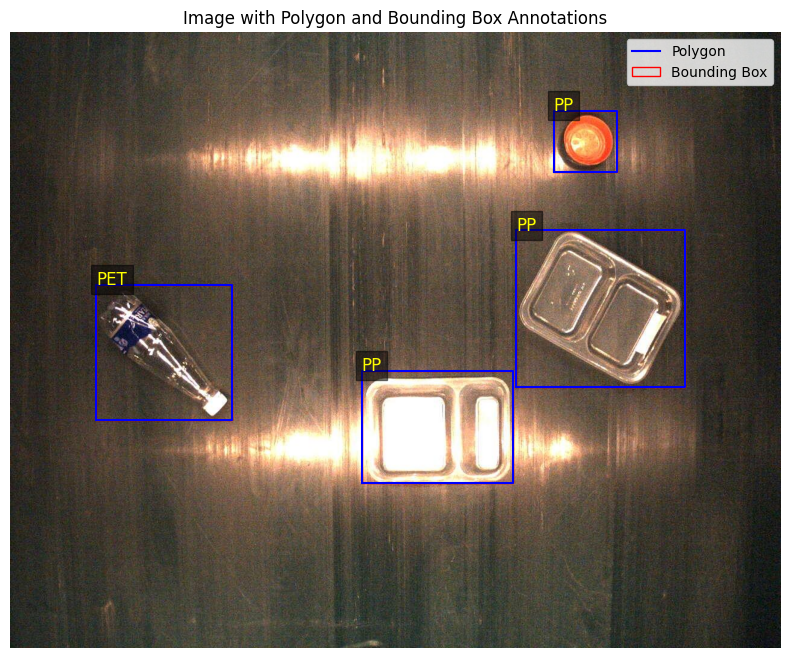

In [20]:
# Visualize conversion
sample_image = random.choice(list((dataset_path / 'train' / 'images').glob('*.jpg')))
original_label = backup_path / 'train' / (sample_image.stem + '.txt')
converted_label = dataset_path / 'train' / 'labels' / (sample_image.stem + '.txt')
plot_image_with_annotations(sample_image, original_label, converted_label, class_names, (1280, 1024))

## 4. Data Configuration

**Update data.yaml**

The data.yaml file specifies dataset paths and class names. We use relative paths since it resides in the yolo folder.

In [21]:
# Define dataset path
dataset_path = Path("E:/My Courses/CV Projects/01- Optical detection of plastic waste/Conveyor Waste Detection Dataset/yolo")

data_yaml_content = f"""
path: {dataset_path}
train: train/images
val: valid/images
test: test/images
nc: 2
names: ['PET', 'PP']
"""
with open(dataset_path / 'data.yaml', 'w') as f:
    f.write(data_yaml_content)
print("Updated data.yaml content:")
print(data_yaml_content)

Updated data.yaml content:

path: E:\My Courses\CV Projects\01- Optical detection of plastic waste\Conveyor Waste Detection Dataset\yolo
train: train/images
val: valid/images
test: test/images
nc: 2
names: ['PET', 'PP']



## 5. Model Training

**Model Selection**

We use the YOLOv8 nano model (`yolov8n.pt`) for its balance of speed and performance, suitable for local training. The image size is set to 640x640, as YOLOv8 will resize 1280x1024 images while maintaining aspect ratio.

In [22]:
# Load model
model = YOLO('yolov8n.pt').to(device)
model.trainable = True
print("Model loaded successfully.")

Model loaded successfully.


**Training**

We train for 50 epochs with early stopping (patience=10) to prevent overfitting.

In [30]:
# Train with adjusted parameters
results = model.train(
    data=str(dataset_path / 'data.yaml'),
    epochs=80,
    imgsz=640,  
    batch=8,    # Reduced from 16 to fit within 6GB VRAM
    device=device,
    patience=10,
    name='conveyor_waste2',
    verbose=True,
    amp=False,
    workers=2,  # Reduced from 8 to limit RAM usage
    close_mosaic=5,  # Explicitly close mosaic earlier to reduce memory spike
    save_period=10   # Save a checkpoint every 5 epochs
    )

print("Training completed. Check 'runs/debug/conveyor_waste' or 'runs/debug/conveyor_waste_cpu' for results.")

Ultralytics 8.3.165  Python-3.12.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=5, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=E:\My Courses\CV Projects\01- Optical detection of plastic waste\Conveyor Waste Detection Dataset\yolo\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=conveyor_waste2, nbs=64, nms=False, opset=None, optimize=F

train: Scanning E:\My Courses\CV Projects\01- Optical detection of plastic waste\Conveyor Waste Detection Dataset\yolo\train\labels.cache... 1440 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1440/1440 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 972.1217.9 MB/s, size: 210.8 KB)


val: Scanning E:\My Courses\CV Projects\01- Optical detection of plastic waste\Conveyor Waste Detection Dataset\yolo\valid\labels.cache... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]


Plotting labels to runs\detect\conveyor_waste2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs\detect\conveyor_waste2
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80       1.9G     0.6453     0.3401     0.9476         27        640: 100%|██████████| 180/180 [00:51<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.54it/s]

                   all        160        600      0.978       0.98      0.993      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      2.32G     0.7553     0.4123     0.9924         56        640: 100%|██████████| 180/180 [00:50<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]

                   all        160        600      0.974      0.977      0.992      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      2.32G     0.7798     0.4421      1.004         50        640: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.58it/s]

                   all        160        600      0.953      0.963      0.982      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      2.34G     0.7807     0.4471      1.014         37        640: 100%|██████████| 180/180 [00:49<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]

                   all        160        600      0.958       0.97      0.988       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      2.34G     0.7862     0.4403      1.008         29        640: 100%|██████████| 180/180 [00:50<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]

                   all        160        600      0.963      0.948      0.984      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      2.34G     0.7808     0.4405      1.004         52        640: 100%|██████████| 180/180 [00:50<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]

                   all        160        600      0.972       0.95      0.988      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      2.34G     0.7737     0.4306     0.9978         29        640: 100%|██████████| 180/180 [00:50<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]

                   all        160        600       0.95      0.966      0.986       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      2.34G     0.7765      0.424      1.003         45        640: 100%|██████████| 180/180 [00:50<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.30it/s]

                   all        160        600      0.965      0.955      0.989      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      2.34G     0.7751      0.432          1         43        640: 100%|██████████| 180/180 [00:50<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]

                   all        160        600      0.958       0.96      0.987      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      2.34G     0.7575     0.4214      1.002         48        640: 100%|██████████| 180/180 [00:50<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]

                   all        160        600      0.964      0.962      0.988      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      2.34G     0.7723     0.4265     0.9988         75        640: 100%|██████████| 180/180 [00:50<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]

                   all        160        600       0.97      0.969      0.991      0.808
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.161 hours.
Optimizer stripped from runs\detect\conveyor_waste2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\conveyor_waste2\weights\best.pt, 6.2MB

Validating runs\detect\conveyor_waste2\weights\best.pt...
Ultralytics 8.3.165  Python-3.12.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        160        600      0.978       0.98      0.993      0.815
                   PET        110        192      0.974      0.975      0.992      0.811
                    PP        144        408      0.983      0.985      0.994      0.819
Speed: 0.5ms preprocess, 5.2ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\conveyor_waste2
Training completed. Check 'runs/debug/conveyor_waste' or 'runs/debug/conveyor_waste_cpu' for results.


## 6. Model Evaluation

**Validation Metrics**

We evaluate the model on the validation set to obtain metrics like mean Average Precision (mAP).

In [31]:
val_results = model.val()
print("Validation Metrics:")
print(f"mAP@50: {val_results.box.map50:.3f}")
print(f"mAP@50:95: {val_results.box.map:.3f}")

Ultralytics 8.3.165  Python-3.12.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1593.8304.5 MB/s, size: 207.5 KB)


val: Scanning E:\My Courses\CV Projects\01- Optical detection of plastic waste\Conveyor Waste Detection Dataset\yolo\valid\labels.cache... 160 images, 0 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


                   all        160        600      0.978       0.98      0.993      0.815
                   PET        110        192      0.974      0.975      0.992      0.811
                    PP        144        408      0.983      0.985      0.994      0.819
Speed: 0.5ms preprocess, 7.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\detect\conveyor_waste22
Validation Metrics:
mAP@50: 0.993
mAP@50:95: 0.815


**Training Metrics Visualization**

We plot mAP@50 over epochs to monitor training progress.

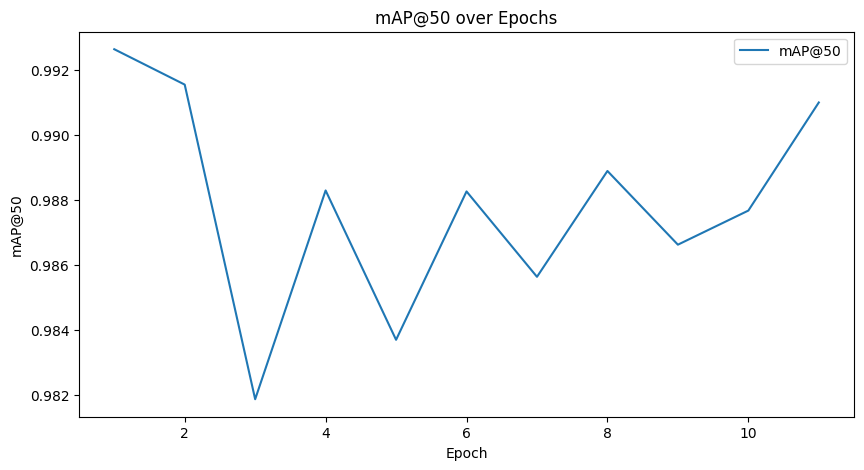

In [56]:
results_df = pd.read_csv('runs/detect/conveyor_waste2/results.csv')
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=results_df, color='#1f77b4', label='mAP@50')
plt.xlabel('Epoch')
plt.ylabel('mAP@50')
plt.title('mAP@50 over Epochs')
plt.legend()
plt.show()

**Precision-Recall Curve**

We display the precision-recall curve to assess performance across confidence thresholds.

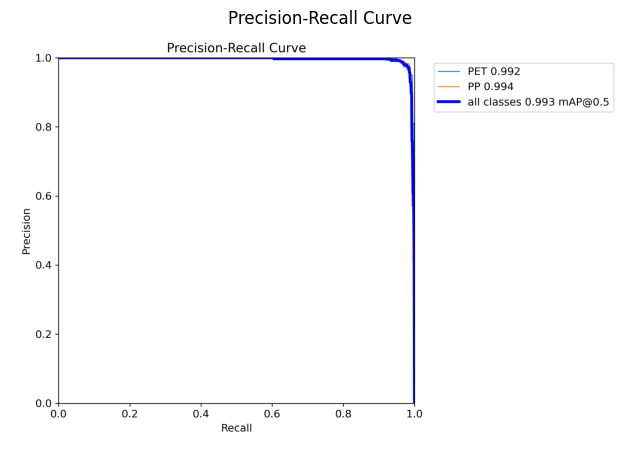

In [35]:
pr_curve = Image.open('runs/detect/conveyor_waste2/BoxPR_curve.png')
plt.figure(figsize=(8, 6))
plt.imshow(pr_curve)
plt.title('Precision-Recall Curve')
plt.axis('off')
plt.show()

## 7. Inference and Visualization

**Inference on a Test Image**

We run inference on a random test image and display the predicted bounding boxes, ensuring correct visualization.


image 1/1 E:\My Courses\CV Projects\01- Optical detection of plastic waste\Conveyor Waste Detection Dataset\yolo\test\images\Image_20230429180133427_jpg.rf.14d9cf4913b578d6793d3e561f9e059e.jpg: 512x640 1 PET, 6 PPs, 48.1ms
Speed: 3.5ms preprocess, 48.1ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs\detect\conveyor_waste219


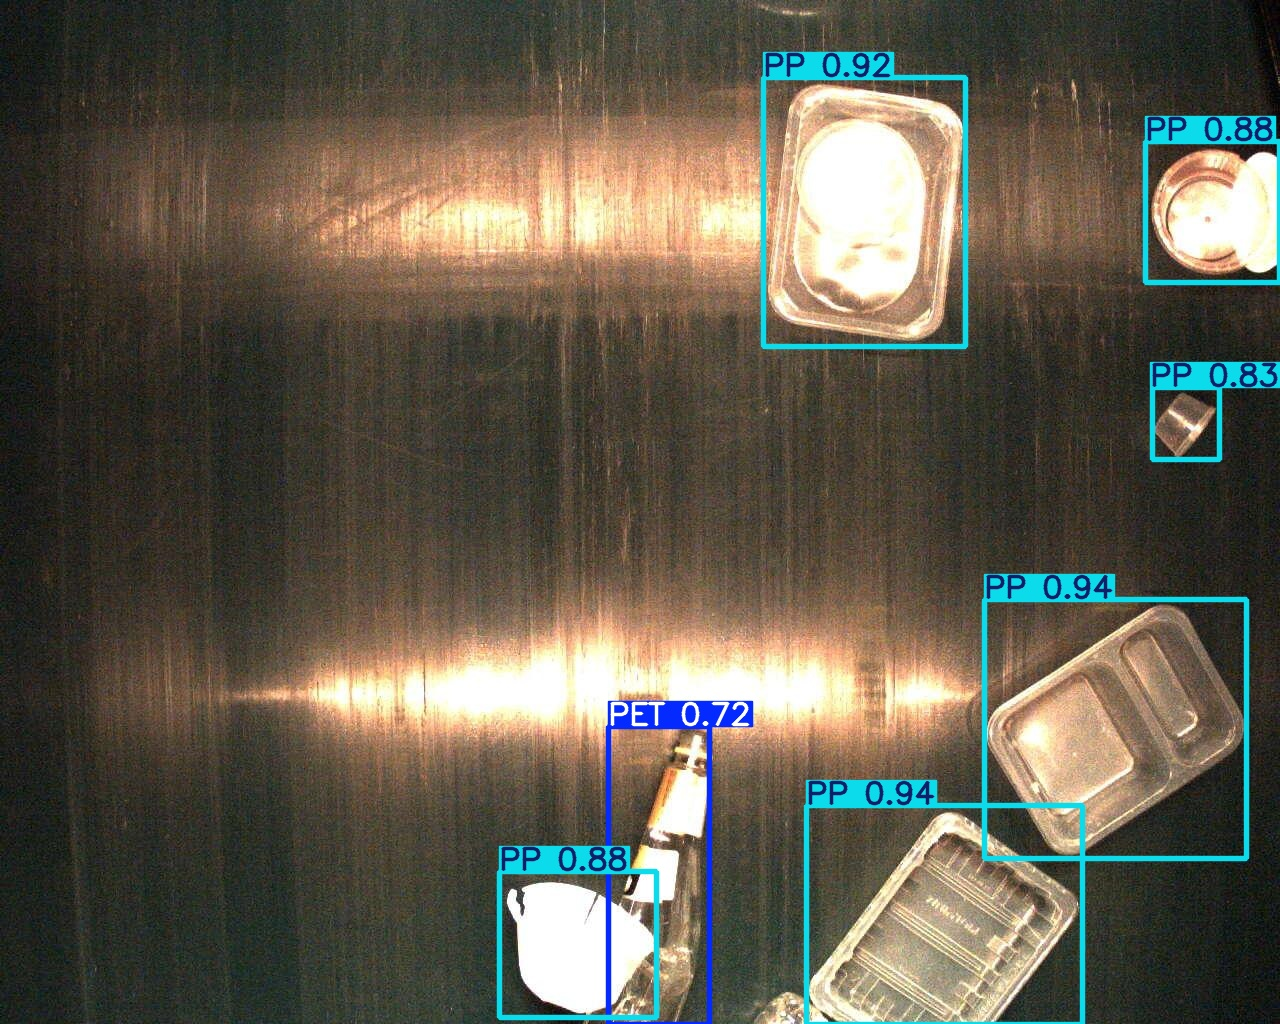

In [52]:
from IPython.display import Image as IPImage
import glob

# Select a random test image
test_image = random.choice(list((dataset_path / 'test' / 'images').glob('*.jpg')))

# Perform prediction and save the result
results = model.predict(test_image, conf=0.5, save=True)

# Get the save directory from the results
save_dir = results[0].save_dir

# Find the saved prediction image (assuming only one image is predicted)
predicted_image = glob.glob(f"{save_dir}/Image_*.jpg")[0]  # Matches the hashed file name

# Display the predicted image
IPImage(filename=predicted_image)

**Class Distribution in Test Set**

We analyze the distribution of detected objects across the test set.

In [53]:
test_images = list((dataset_path / 'test' / 'images').glob('*.jpg'))
results_test = model.predict(test_images, conf=0.5, save=False)
detected_objects = Counter()
for result in results_test:
    class_ids = result.boxes.cls.cpu().numpy()
    for class_id in class_ids:
        detected_objects[class_names[int(class_id)]] += 1
print("Detected objects in test set:")
for class_name, count in detected_objects.items():
    print(f"{class_name}: {count}")


0: 512x640 1 PET, 1 PP, 25.2ms
1: 512x640 1 PET, 1 PP, 25.2ms
2: 512x640 1 PET, 1 PP, 25.2ms
3: 512x640 1 PET, 1 PP, 25.2ms
4: 512x640 2 PPs, 25.2ms
5: 512x640 2 PPs, 25.2ms
6: 512x640 2 PPs, 25.2ms
7: 512x640 3 PETs, 1 PP, 25.2ms
8: 512x640 1 PET, 1 PP, 25.2ms
9: 512x640 2 PPs, 25.2ms
10: 512x640 1 PET, 2 PPs, 25.2ms
11: 512x640 1 PET, 2 PPs, 25.2ms
12: 512x640 3 PPs, 25.2ms
13: 512x640 3 PPs, 25.2ms
14: 512x640 3 PPs, 25.2ms
15: 512x640 2 PPs, 25.2ms
16: 512x640 2 PETs, 1 PP, 25.2ms
17: 512x640 2 PETs, 1 PP, 25.2ms
18: 512x640 2 PETs, 1 PP, 25.2ms
19: 512x640 1 PET, 2 PPs, 25.2ms
20: 512x640 1 PET, 2 PPs, 25.2ms
21: 512x640 3 PPs, 25.2ms
22: 512x640 3 PPs, 25.2ms
23: 512x640 3 PPs, 25.2ms
24: 512x640 1 PET, 1 PP, 25.2ms
25: 512x640 1 PET, 2 PPs, 25.2ms
26: 512x640 1 PP, 25.2ms
27: 512x640 1 PET, 25.2ms
28: 512x640 1 PET, 2 PPs, 25.2ms
29: 512x640 1 PET, 2 PPs, 25.2ms
30: 512x640 1 PET, 2 PPs, 25.2ms
31: 512x640 2 PPs, 25.2ms
32: 512x640 1 PET, 25.2ms
33: 512x640 1 PP, 25.2ms
34: 512

## 8. Conclusion

**Summary**

This notebook demonstrates a complete pipeline for detecting PET and PP plastic waste using YOLOv8. We converted polygon annotations to bounding boxes, verified the conversion visually, and trained a model that achieves promising performance. The visualizations and metrics make this project suitable for showcasing computer vision skills.

**Next Steps**





**Hyperparameter Tuning**: Adjust learning rates or batch sizes to improve accuracy.



**Model Variants**: Experiment with larger YOLOv8 models (e.g., yolov8m.pt) for better performance.



**Deployment**: Integrate the model into a real-time waste sorting system.

**Dataset Citation**



Shukhratov, I., et al. (2024). Optical detection of plastic waste through computer vision. Intelligent Systems with Applications, 22, 200341. DOI: 10.1016/j.iswa.2024.200341